In [1]:
# Use autoreload extension so agent definition is always up to date.
# Src: https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

# Initial imports
from unityagents import UnityEnvironment
from collections import deque
from matplotlib import pyplot as plt
import time
import seaborn as sns
import numpy as np
import os
import torch

import BananaAgent as Agents

sns.set_style()

print(f"Cuda available? {torch.cuda.is_available()}")

Cuda available? True


In [2]:
# TODO: Check if Banana is available
# Load environment and get initial brain
env = UnityEnvironment("Banana/Banana.x86_64", no_graphics=True)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# Initialize environment for use of the agent
env_info = env.reset(train_mode=True)[brain_name]
action_space = brain.vector_action_space_size
state_space = env_info.vector_observations.size

print(f"Action space: {action_space}")
print(f"State space: {state_space}")


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Action space: 4
State space: 37


In [3]:
def do_episode(environment, agent):
    """Performs a single episode using the given environment and agent

    Args:
        environment (env): Environment that will perform the simulation
        agent (Agent): Agent that will traverse the environment

    Returns:
        (float, int): Total score and steps of the episode
    """
    episode_score = 0
    env_info = env.reset(train_mode=True)[brain_name]

    # Start the agent
    state = env_info.vector_observations[0]
    next_action = agent.start(state)

    # Take the first action
    env_info = env.step(next_action)[brain_name]

    while not env_info.local_done[0]:
        # Take a step from the agent
        reward = env_info.rewards[0]
        episode_score += reward
        state = env_info.vector_observations[0]

        next_action = agent.step(reward, state)

        # Perform action
        env_info = env.step(next_action)[brain_name]
    
    # Register last reward to the agent
    reward = env_info.rewards[0]
    episode_score += reward
    agent.end(reward)

    return episode_score

In [4]:
def create_agents(state_space, action_space):
    """Create the list of agents to test

    Returns:
        list: List of agents
    """
    agent_parameters = {
        "state_size":state_space,
        "action_size" :action_space,
        "gamma":0.99,
        "alpha":5e-4,
        "tau": 1e-3,
        "batch_size": 64,
        "buffer_size": int(1e5),
        "learn_every": 4,
        "seed": 3429
    }


    agents = [
        # Agents.RandomAgent(state_space, action_space, agent_gamma, agent_alpha, seed),
        Agents.BananaAgent(**agent_parameters),
        Agents.BananaAgentDouble(**agent_parameters)
    ]

    return agents

In [5]:
def do_experiment(environment, agent, episodes, print_every):
    """Performs an experiment on the given agent.

    Args:
        environment (any): Environment to use
        agent (Agent): Agent that follows the "Agent" interface
        episodes (int): Amount of episodes to perform
        print_every (int): How often to print the episode information

    Returns:
        (array_like, array_like): Scores and times that the agent took per episode
    """
    scores = np.zeros(episodes)
    times = np.zeros(episodes)

    for i in range(episodes):
        start_time = time.time()
        scores[i] = do_episode(environment, agent)
        times[i] = time.time() - start_time

        ep = i+1
        if ep % print_every == 0:
            print(f"{agent.agent_name()} :: ({ep}/{episodes}) AVG {np.average(scores[max(0, i-print_every):])}")
    
    return scores, times

BananaAgent :: (400/2000) AVG 0.23
BananaAgent :: (800/2000) AVG 1.1355402873204248
BananaAgent :: (1200/2000) AVG 2.7210657785179015
BananaAgent :: (1600/2000) AVG 5.142322097378277
BananaAgent :: (2000/2000) AVG 11.718204488778055
BananaAgentDouble :: (400/2000) AVG 0.2065
BananaAgentDouble :: (800/2000) AVG 1.2392254840724548
BananaAgentDouble :: (1200/2000) AVG 2.7751873438801
BananaAgentDouble :: (1600/2000) AVG 5.2559300873907615
BananaAgentDouble :: (2000/2000) AVG 12.077306733167083


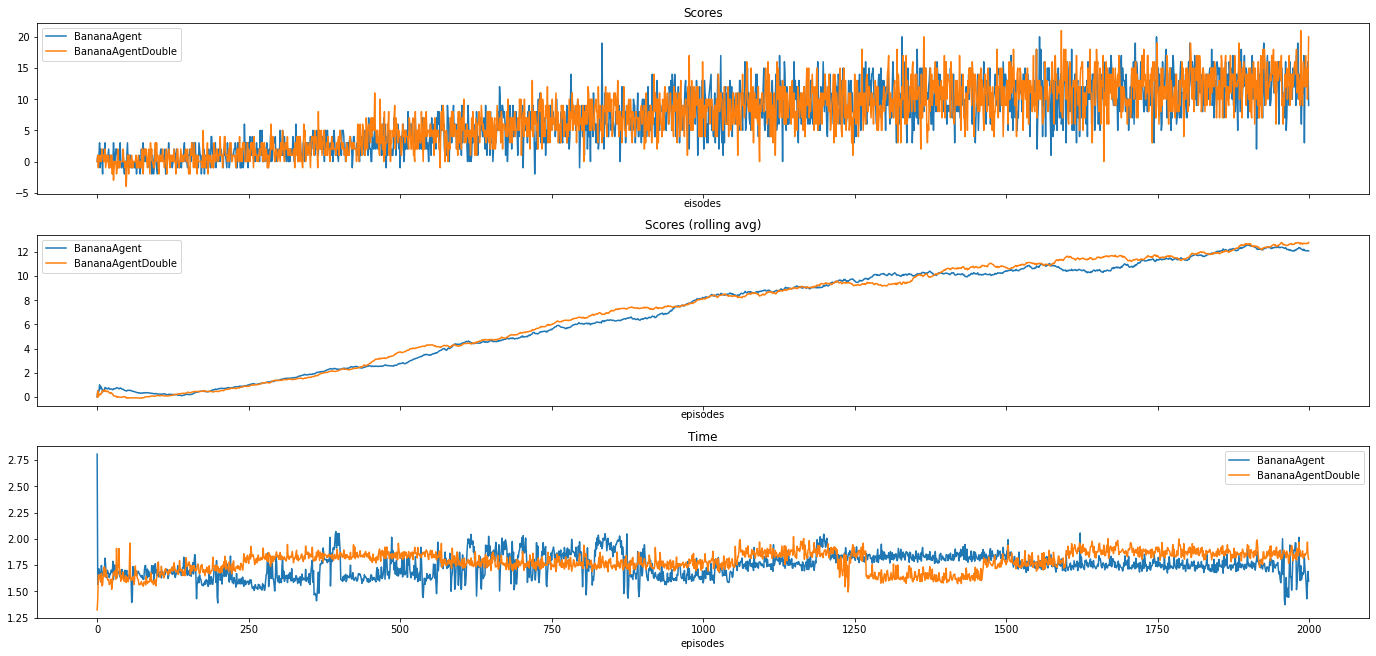

In [6]:
average_window = 100

episodes = 2000
print_every = 400

# Perform each episode of the training
figure, axis = plt.subplots(3, 1, figsize=(19, 9), constrained_layout=True, sharex="all")
axis[0].set_title("Scores")
axis[0].set_xlabel("eisodes")
axis[1].set_title("Scores (rolling avg)")
axis[1].set_xlabel("episodes")
axis[2].set_title("Time")
axis[2].set_xlabel("episodes")

for agent in create_agents(state_space, action_space):
    # Do experiment
    scores, times = do_experiment(env, agent, episodes, print_every)
    agent_name = agent.agent_name()

    # Save agent
    torch.save(agent, f"agents/{agent_name}.pt")

    # Plot the statistics
    x = np.arange(episodes)
    sns.lineplot(x=x, y=scores, label=agent_name, ax=axis[0])

    avg = [np.average(scores[max(0, n-average_window):n+1]) for n in range(episodes)]
    sns.lineplot(x=x, y=avg, label=agent_name, ax=axis[1])
    
    sns.lineplot(x=x, y=times, label=agent_name, ax=axis[2])

plt.show()

    


In [7]:
# Close environment
env.close()